In [ ]:
# To download kssl dataset
# pip install gdown (see cell below)
# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2

# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

In [1]:
!pip install gdown 
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.5.1
    Uninstalling gdown-4.5.1:
      Successfully uninstalled gdown-4.5.1


In [2]:
!pip install spanda

  Preparing metadata (setup.py) ... done
  Created wheel for brukeropusreader: filename=brukeropusreader-1.3.4-py3-none-any.whl size=5311 sha256=b68a4d4bd9e83b78a4d10d50146b348e3393404216d9be9a22b72982ccbad59a
  Stored in directory: /root/.cache/pip/wheels/6a/0d/86/91cddedf53ade4d06446f0efb197520a25ccc18b6725c65378
Successfully built brukeropusreader


In [3]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from spanda.data.transforms.kssl import (get_spectra_files, to_spectra, rand_w_avg, AnalytesTfm)
from fastcore.parallel import parallel

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [4]:
path = Path('/root/kssl-mirs-v2')

In [5]:
path.ls()

(#46305) [Path('/root/kssl-mirs-v2/174608'),Path('/root/kssl-mirs-v2/174916'),Path('/root/kssl-mirs-v2/19897'),Path('/root/kssl-mirs-v2/68409'),Path('/root/kssl-mirs-v2/86746'),Path('/root/kssl-mirs-v2/172147'),Path('/root/kssl-mirs-v2/199430'),Path('/root/kssl-mirs-v2/180551'),Path('/root/kssl-mirs-v2/25251'),Path('/root/kssl-mirs-v2/176480')...]

In [6]:
def is_valid(path):
    is_analyte_pos = AnalytesTfm(analytes=[725])(path).item() > 0
    has_spectra = len(get_spectra_files(path)) > 0
    return is_analyte_pos and has_spectra

In [7]:
%%time 
mask = parallel(is_valid, path.ls(), n_workers=8, progress=True)
paths = path.ls()[mask]

CPU times: user 15.5 s, sys: 3.57 s, total: 19.1 s
Wall time: 2min 25s


In [8]:
class Spectra(Tensor): 
    def show(self, ctx=None, figsize=(12,4), **kwargs):
        spectra = self
        if ctx is None: _,ctx = plt.subplots(figsize=figsize)
        wn = np.arange(4000, 600, -2)
        #ctx.imshow(im, **{**self._show_args, **kwargs})
        ctx.set_xlim(np.max(wn), np.min(wn))
        ctx.set(xlabel='Wavenumber', ylabel='Absorbance')
        ctx.set_axisbelow(True)
        for spectrum in spectra:
            _ = ctx.plot(wn, spectrum, c='steelblue', lw=0.5)
        ctx.grid(True, which='both')
        return ctx

@Transform
def snv(x: Spectra, # Spectrum 
       ) -> Spectra: # Standard Normal Variate of spectrum
    "Standard Normal Variate Transform of input spectrum"
    mean, std = torch.mean(x), torch.std(x)
    return (x - mean)/std

In [9]:
x_tfms = [get_spectra_files, to_spectra, rand_w_avg, snv]
y_tfms = [AnalytesTfm(analytes=[725]), torch.log10]

In [10]:
splits = RandomSplitter(seed=42)(paths)
dsets = Datasets(paths, [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=16, num_workers=8, drop_last=True)
dls.train.one_batch()[0].shape

torch.Size([16, 1, 1700])

In [15]:
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
x = dls.train.one_batch()[0]
#model(x)

In [16]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

SuggestedLRs(valley=0.0002290867705596611)

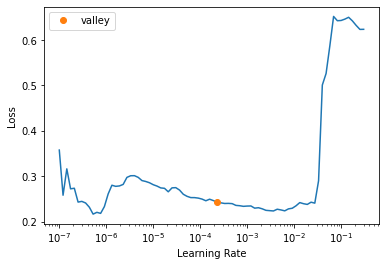

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(80, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.136157,0.129192,0.439284,01:51
1,0.132853,0.121086,0.474467,01:45
2,0.117660,0.114938,0.501147,01:47
3,0.106583,0.104054,0.548385,01:47
4,0.104988,0.108631,0.528521,01:45
5,0.100783,0.137452,0.403434,01:45
6,0.099762,0.098149,0.574017,01:45
7,0.095312,0.101321,0.560250,01:45
8,0.084350,0.081605,0.645821,01:45
9,0.084718,0.082826,0.640518,01:53


In [20]:
learn.save('xresnet18-v2-80-epochs-k-ex-snv-lr-1e-3-r2-0.84')

Path('models/xresnet18-v2-80-epochs-k-ex-snv-lr-1e-3-r2-0.84.pth.pth')